In [3]:
!pip install pmdarima

  Using cached pmdarima-1.8.0-cp38-cp38-win_amd64.whl (616 kB)


In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [6]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('Content/Stocks/acgl.us.txt',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [7]:
stock_data.head()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2005-02-25,13.583,13.693,13.430,13.693,156240,0
2005-02-28,13.697,13.827,13.540,13.827,370509,0
2005-03-01,13.780,13.913,13.720,13.760,224484,0
2005-03-02,13.717,13.823,13.667,13.810,286431,0
2005-03-03,13.783,13.783,13.587,13.630,193824,0


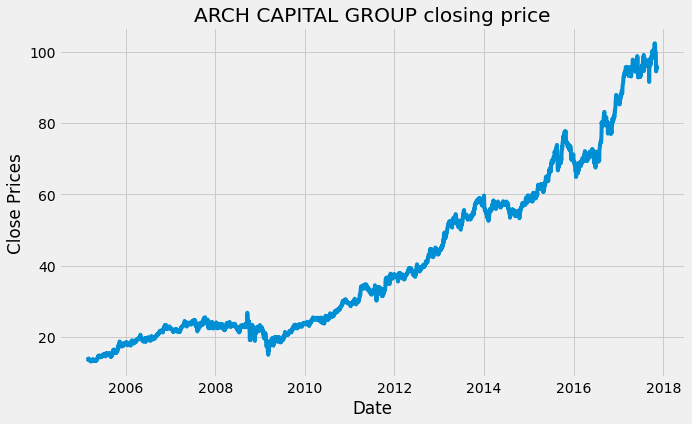

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<AxesSubplot:ylabel='Density'>

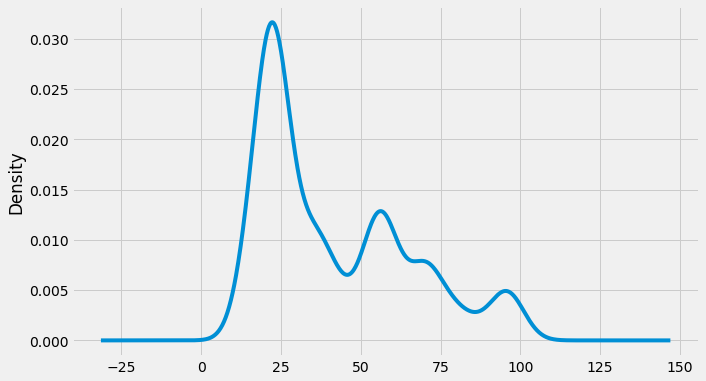

In [9]:
#Distribution of the dataset
stock_data['Close'].plot(kind='kde')

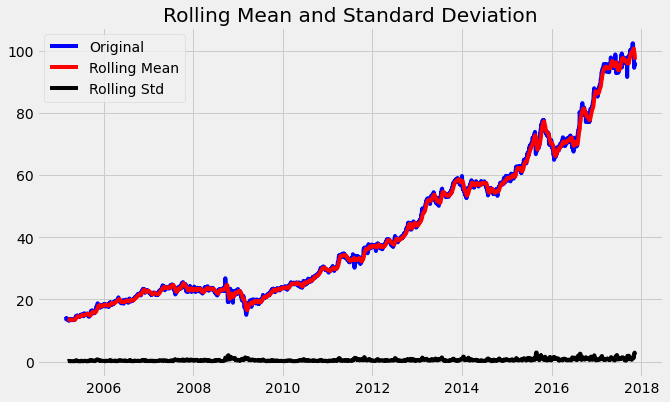

Results of dickey fuller test
Test Statistics                   1.374899
p-value                           0.996997
No. of lags used                  5.000000
Number of observations used    3195.000000
critical value (1%)              -3.432398
critical value (5%)              -2.862445
critical value (10%)             -2.567252
dtype: float64


In [10]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_data['Close'])

<Figure size 720x432 with 0 Axes>

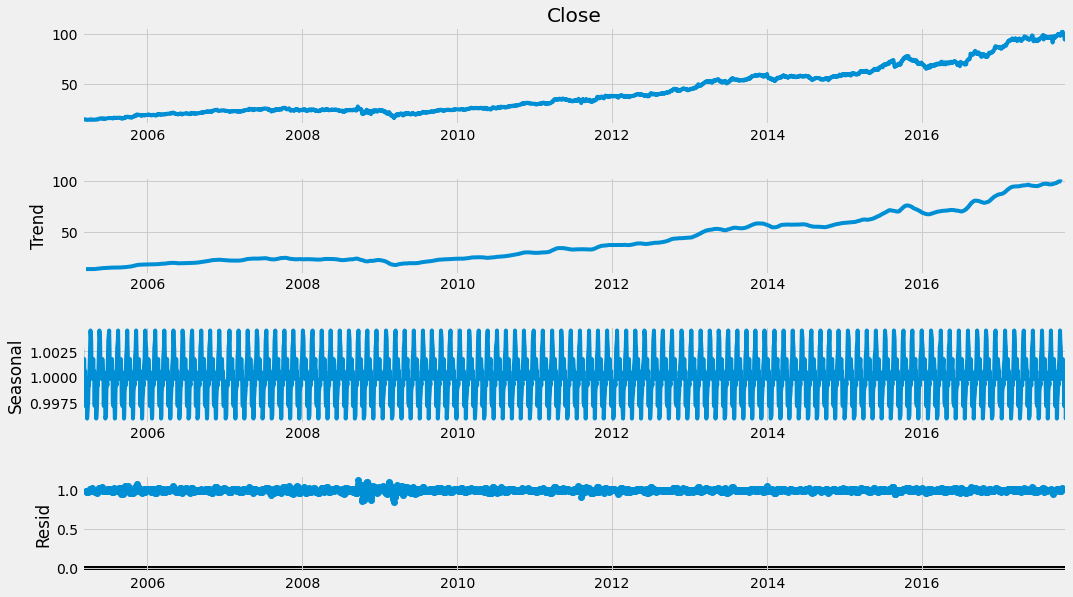

In [11]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(stock_data['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


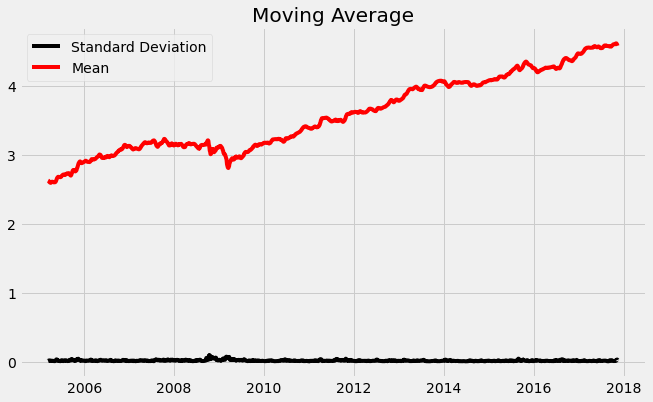

In [12]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_data['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

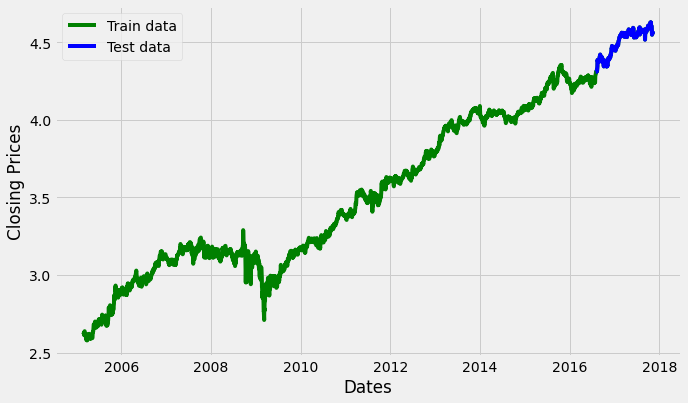

In [13]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16491.508, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16525.992, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16527.964, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16488.323, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16527.157, Time=1.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-16527.120, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-16528.810, Time=1.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-16526.020, Time=2.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-16524.974, Time=1.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16525.435, Time=0.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16516.417, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-16527.597, Time=0.54 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 13.388 seconds
  

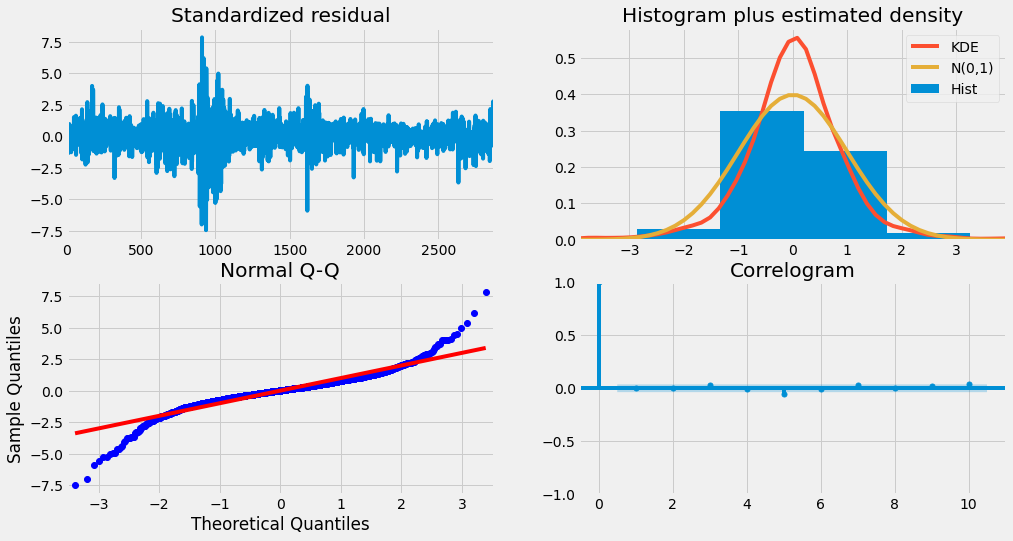

In [14]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [15]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  

print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2876
Model:                 ARIMA(1, 1, 2)   Log Likelihood                8274.158
Method:                       css-mle   S.D. of innovations              0.014
Date:                Fri, 02 Apr 2021   AIC                         -16538.316
Time:                        09:20:41   BIC                         -16508.496
Sample:                             1   HQIC                        -16527.567
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      3.935      0.000       0.000       0.001
ar.L1.D.Close     0.9145      0.040     22.745      0.000       0.836       0.993
ma.L1.D.Close    -1.0351      0.045    -

In [16]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

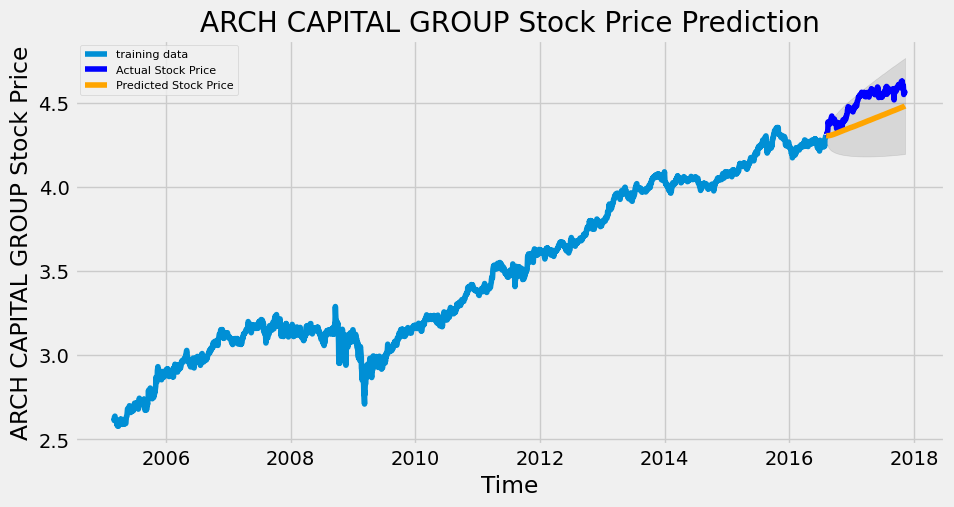

In [17]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.015076505384038574
MAE: 0.11500951098768375
RMSE: 0.12278642182276742
MAPE: 0.025397358257645847
